<a href="https://colab.research.google.com/github/Bageshjha/MultiAI-Agent-Chatbot/blob/main/Multi_AI_Agents_Chatbots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install langchain langgraph langsmith langchain_groq langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.1/417.1 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.45
    Uninstalling langchain-core-0.3.45:
      Successfully uninstalled langchain-core-0.3.45
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.6
    Uninstalling langchain-text-splitters-0.3.6:
      Successfully uni

In [6]:
from typing import Annotated
from typing import TypedDict

In [7]:
!pip install arxiv wikipedia

In [8]:
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

In [9]:
arxiv = ArxivAPIWrapper(top_k_results=1, doc_content_chars=450)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv)

wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars=450)
wiki_tool = WikipediaQueryRun(api_wrapper=wiki)

In [10]:
wiki_tool.invoke("who is elon musk")

'Page: Errol Musk\nSummary: Errol Graham Musk (born 1946) is a South African businessman and politician, member of the Musk family, and father of Elon Musk. He served on the Pretoria City Council, and became a member of South Africa\'s Progressive Federal Party before resigning over political disagreements. As a businessman, he worked as a mechanical engineering consultant, developed properties, and invested in various ventures including emerald trading.\nErrol Musk had three children with his first wife Maye Haldeman: Elon Musk, Kimbal Musk and Tosca Musk. Haldeman divorced him, saying he was abusive. Errol Musk had two other marriages and four other children. He faced criticism from his son Elon, who called him a "terrible human being".\n\n'

In [11]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time on the performance of\nLlama-v2 models. We find that dropping dreeper attention layers only marginally\ndecreases performance but leads to the best speedups alongside dropping entire\nlayers. For example, removing 33\\% of attention layers in a 13B Llama2 model\nresults in a 1.8\\% drop in average performance over the OpenLLM benchmark. We\nalso observe that skipping layers except the latter layers reduces performances\nfor more layers skipped, except for skipping the attention layers."

In [12]:
tools = [wiki_tool,arxiv_tool]

In [13]:
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [14]:
from langgraph.graph import StateGraph, START, END

In [15]:
graph_builder = StateGraph(State)

In [16]:
from langchain_groq import ChatGroq

In [17]:
from google.colab import userdata
groq_api_key = userdata.get('groq-fastapi')

In [18]:
llm = ChatGroq(groq_api_key=groq_api_key, model_name = 'llama-3.1-8b-instant')

In [19]:
llm_tools = llm.bind_tools(tools = tools)

In [20]:
def chatbot(state : State):
  return {'messages': [llm_tools.invoke(state['messages'])]}

In [21]:
from langgraph.prebuilt import ToolNode, tools_condition
tool_node = ToolNode(tools=tools)

In [22]:
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_edge(START, 'chatbot')
graph_builder.add_node('tools',tool_node)
graph_builder.add_conditional_edges('chatbot',tools_condition)
graph_builder.add_edge('tools','chatbot')
graph_builder.add_edge('chatbot',END)

In [23]:
graph = graph_builder.compile()

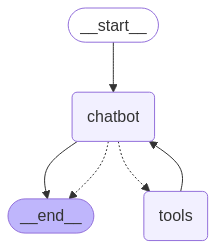

In [24]:
from IPython.display import Image , display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass


In [25]:
user_input = "hi there!, My name is jack"

events = graph.stream(
    {'messages' : [('user',user_input)]},stream_mode='values'
)

for event in events:
  event['messages'][-1].pretty_print()

================================ Human Message =================================

hi there!, My name is jack
================================== Ai Message ==================================

I'm happy to chat with you. What brings you here today?


In [27]:
user_input = "Can You please explain Attention is all you need"

events = graph.stream(
    {'messages' : [('user',user_input)]},stream_mode='values'
)

for event in events:
  event['messages'][-1].pretty_print()

================================ Human Message =================================

Can You please explain Attention is all you need
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_vc8y)
 Call ID: call_vc8y
  Args:
    query: Attention is all you need
================================= Tool Message =================================
Name: wikipedia

Page: Attention Is All You Need
Summary: "Attention Is All You Need" is a 2017 landmark research paper in machine learning authored by eight scientists working at Google. The paper introduced a new deep learning architecture known as the transformer, based on the attention mechanism proposed in 2014 by Bahdanau et al. It is considered a foundational paper in modern artificial intelligence, as the transformer approach has become the main architecture of large language models like those based on GPT. At the time, the focus of the research was on improving Seq2seq techniques for machin